In [2]:
from tsai.all import *
computer_setup()

os              : Windows-10-10.0.22621-SP0
python          : 3.9.13
tsai            : 0.3.5
fastai          : 2.7.11
fastcore        : 1.5.28
torch           : 1.13.1+cpu
cpu cores       : 6
threads per cpu : 2
RAM             : 15.9 GB
GPU memory      : [6.0] GB


# Load data 🔢

In [27]:
##Data needs to be of the format [length, features, sequence]
import sys, os
import pandas as pd

from Preprocessing.preprocessing import preprocessing


df = pd.read_csv('Data\Stock\StockBars\MSFT_Minute')
data_train, data_test ,s = preprocessing(df[:10000],sequence_length = 9, lag=3, TSAI = True, CLF = True)

X, y, splits = combine_split_data([data_train[0], data_test[0]],[data_train[1], data_test[1]])

print(torch.unique(y))

print(X.shape, y.shape)

tensor([0., 1.])
torch.Size([9977, 9, 9]) torch.Size([9977])


# LSTM baseline 🧢

SuggestedLRs(valley=0.002511886414140463)

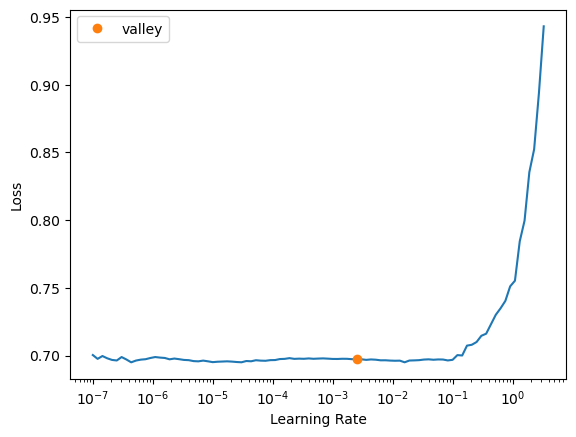

In [28]:
bs = 64
dsets = TSDatasets(X, y, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs)

model = LSTMPlus(9, 2, dls.len)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn.lr_find()

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.695067,0.698584,0.473599,0.436805,00:02
1,0.695528,0.698055,0.477333,0.437816,00:02
2,0.694348,0.696962,0.484840,0.444894,00:02
3,0.693519,0.695486,0.496776,0.462083,00:02
4,0.692559,0.694012,0.508688,0.490394,00:02
5,0.692055,0.692611,0.518515,0.530839,00:02
6,0.691086,0.691568,0.525318,0.542973,00:02
7,0.690460,0.690676,0.529624,0.551062,00:02
8,0.689956,0.690115,0.533697,0.563195,00:02
9,0.689343,0.689556,0.536538,0.569262,00:02


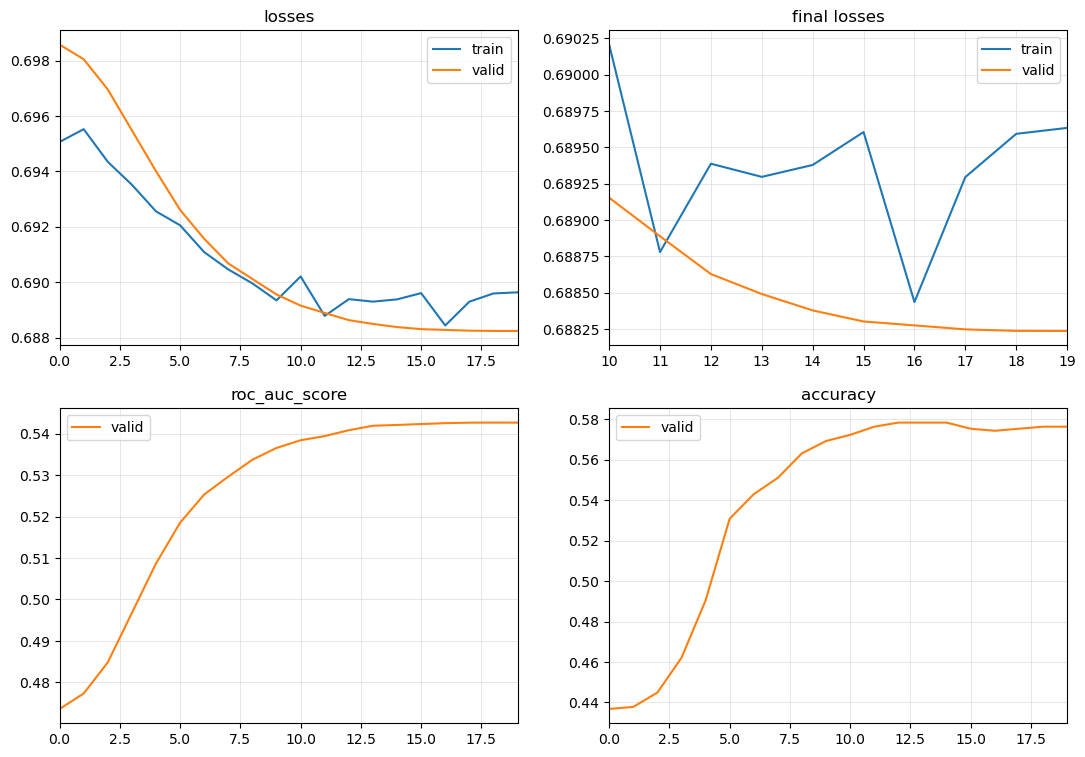


Elapsed time: 55.580496311187744


In [19]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
start = time.time()
learn.fit_one_cycle(20, 2e-5)
print('\nElapsed time:', time.time() - start)

# RNN Baseline

SuggestedLRs(valley=0.004365158267319202)

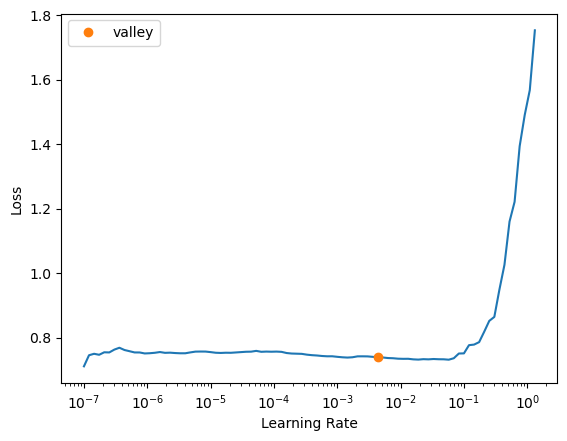

In [20]:
bs = 64
dsets = TSDatasets(X, y, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs)

model = RNNPlus(9, 2, dls.len)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn.lr_find()

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.700805,0.689345,0.515293,0.560162,00:01
1,0.734835,0.705681,0.499713,0.531850,00:01
2,0.731688,0.703451,0.494234,0.528817,00:01
3,0.776065,0.765942,0.511551,0.529828,00:01
4,0.778774,0.736543,0.507138,0.502528,00:01
5,0.797132,0.761009,0.474595,0.433771,00:01
6,0.777136,0.833028,0.523098,0.552073,00:01
7,0.772418,0.809231,0.513600,0.567240,00:01
8,0.761958,0.693992,0.529356,0.572295,00:01
9,0.757888,0.757545,0.493853,0.452983,00:01


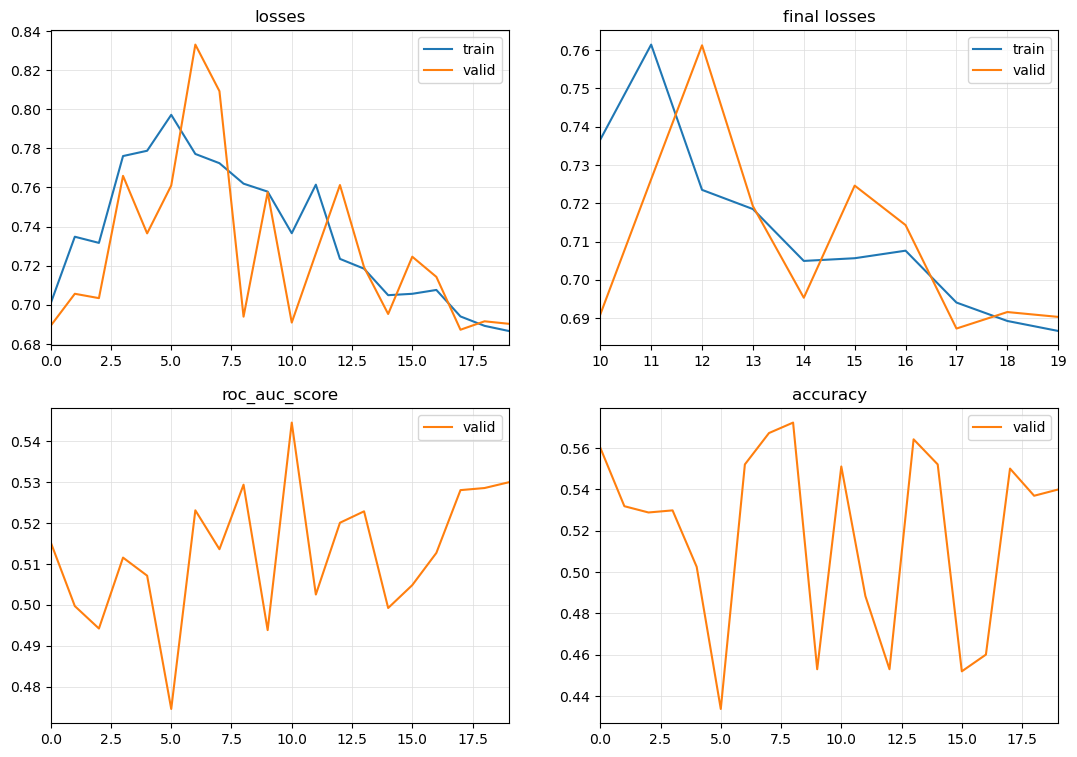


Elapsed time: 31.931852102279663


In [21]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
start = time.time()
learn.fit_one_cycle(20, 5e-2)
print('\nElapsed time:', time.time() - start)

# GRU Baseline

SuggestedLRs(valley=0.0020892962347716093)

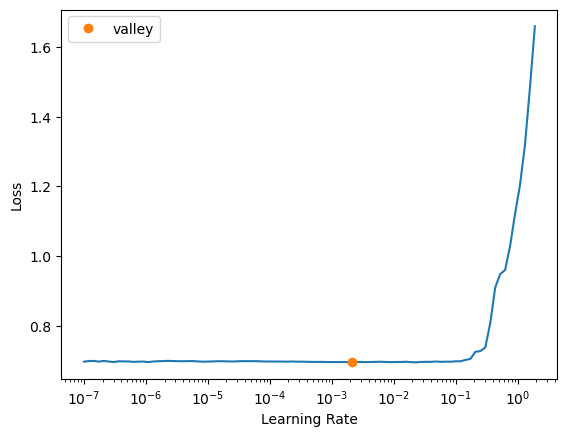

In [22]:
bs = 64
dsets = TSDatasets(X, y, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs)

model = GRUPlus(9, 2, dls.len)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn.lr_find()

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.692311,0.688260,0.531473,0.567240,00:02
1,0.697553,0.729970,0.540461,0.477250,00:02
2,0.727332,0.711045,0.514231,0.537917,00:02
3,0.758713,0.785110,0.511807,0.462083,00:02
4,0.765496,0.731361,0.495752,0.543984,00:01
5,0.758958,0.707495,0.529533,0.534884,00:01
6,0.767871,0.771491,0.503448,0.471183,00:02
7,0.750398,0.782649,0.492549,0.469161,00:02
8,0.745679,0.710884,0.499867,0.498483,00:01
9,0.725070,0.715113,0.511074,0.524773,00:02


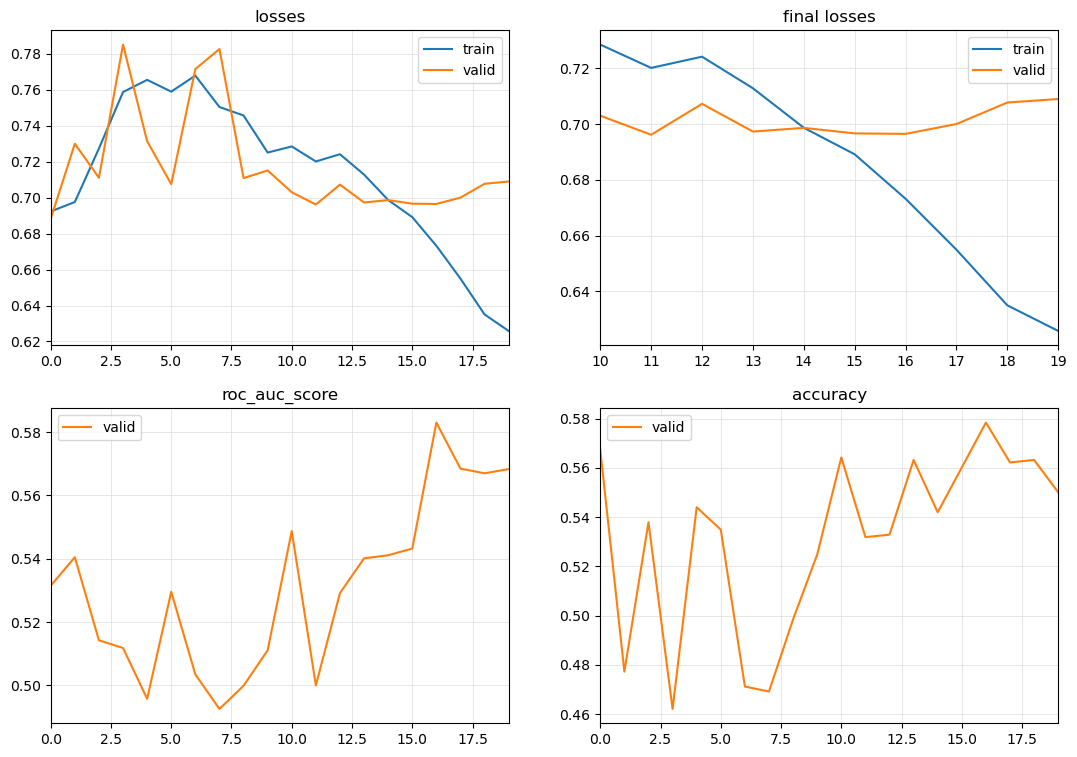


Elapsed time: 48.78488373756409


In [23]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
start = time.time()
learn.fit_one_cycle(20, 5e-2)
print('\nElapsed time:', time.time() - start)

# Parameter tuning

In [24]:
import optuna
from optuna.integration import FastAIPruningCallback

def objective(trial:optuna.Trial):
    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
    hidden_size = trial.suggest_categorical('hidden_size', [25, 50, 100, 200])
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    n_layers = trial.suggest_categorical('n_layers', [1, 2, 4, 8])
    rnn_dropout = trial.suggest_float("rnn_dropout", 0.0, 0.5, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    fc_dropout = trial.suggest_float("fc_dropout", 0.0, 0.5, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
    
    model =LSTMPlus(9, 2, dls.len,
                hidden_size=hidden_size,
                bidirectional=bidirectional,
                n_layers=n_layers,
                rnn_dropout= rnn_dropout,
                fc_dropout=fc_dropout)
    learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=FastAIPruningCallback(trial))

    with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
        learn.fit_one_cycle(15, lr_max=learning_rate)

    # Return the objective value
    return learn.recorder.values[-1][3] # return the validation loss value of the last epoch 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=16)

[I 2023-03-03 11:04:31,680] A new study created in memory with name: no-name-e6dd8336-3376-4138-be64-fb4010ecdccb
[I 2023-03-03 11:06:39,033] Trial 0 finished with value: 0.569261908531189 and parameters: {'hidden_size': 100, 'bidirectional': False, 'n_layers': 4, 'rnn_dropout': 0.30000000000000004, 'fc_dropout': 0.0, 'learning_rate': 8.713735051244402e-05}. Best is trial 0 with value: 0.569261908531189.
[I 2023-03-03 11:07:38,939] Trial 1 finished with value: 0.5581395626068115 and parameters: {'hidden_size': 25, 'bidirectional': False, 'n_layers': 2, 'rnn_dropout': 0.2, 'fc_dropout': 0.30000000000000004, 'learning_rate': 1.390622985508302e-06}. Best is trial 0 with value: 0.569261908531189.
[I 2023-03-03 11:15:52,634] Trial 2 finished with value: 0.5318503379821777 and parameters: {'hidden_size': 50, 'bidirectional': True, 'n_layers': 8, 'rnn_dropout': 0.30000000000000004, 'fc_dropout': 0.30000000000000004, 'learning_rate': 0.0008756162698573231}. Best is trial 0 with value: 0.569261